**Disclaimer**: generative AI was used in the making of this project.

In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma, scoreatpercentile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score

In [481]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data_df = pd.read_csv(file_path)
claims_data_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [482]:
# Claim frequency will be used instead for number of claims as the period of exposure, meaning, the time a claim can occur, is also considered.
# Claim severity is the average claim amount per claim and will be used instead of the claim amount. 
claims_data_df['Frequency'] = claims_data_df['ClaimNb'] / claims_data_df['Exposure'] #Number of claims per year
claims_data_df['Severity'] = claims_data_df['ClaimAmount'] / claims_data_df['ClaimNb'] #Amount per claim

# Drop the original columns and place the new columns at the same position as the original columns 
claims_data = claims_data_df.drop(columns=['ClaimNb'])

# Fill missing values in the 'Severity' column with 0 (meaning no claim occurred)
claims_data['Severity'] = claims_data['Severity'].fillna(0)

# 1. Descriptive Analysis of Risk Variables

In [5]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['Frequency'].sum()
    sev = data[data['Frequency'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

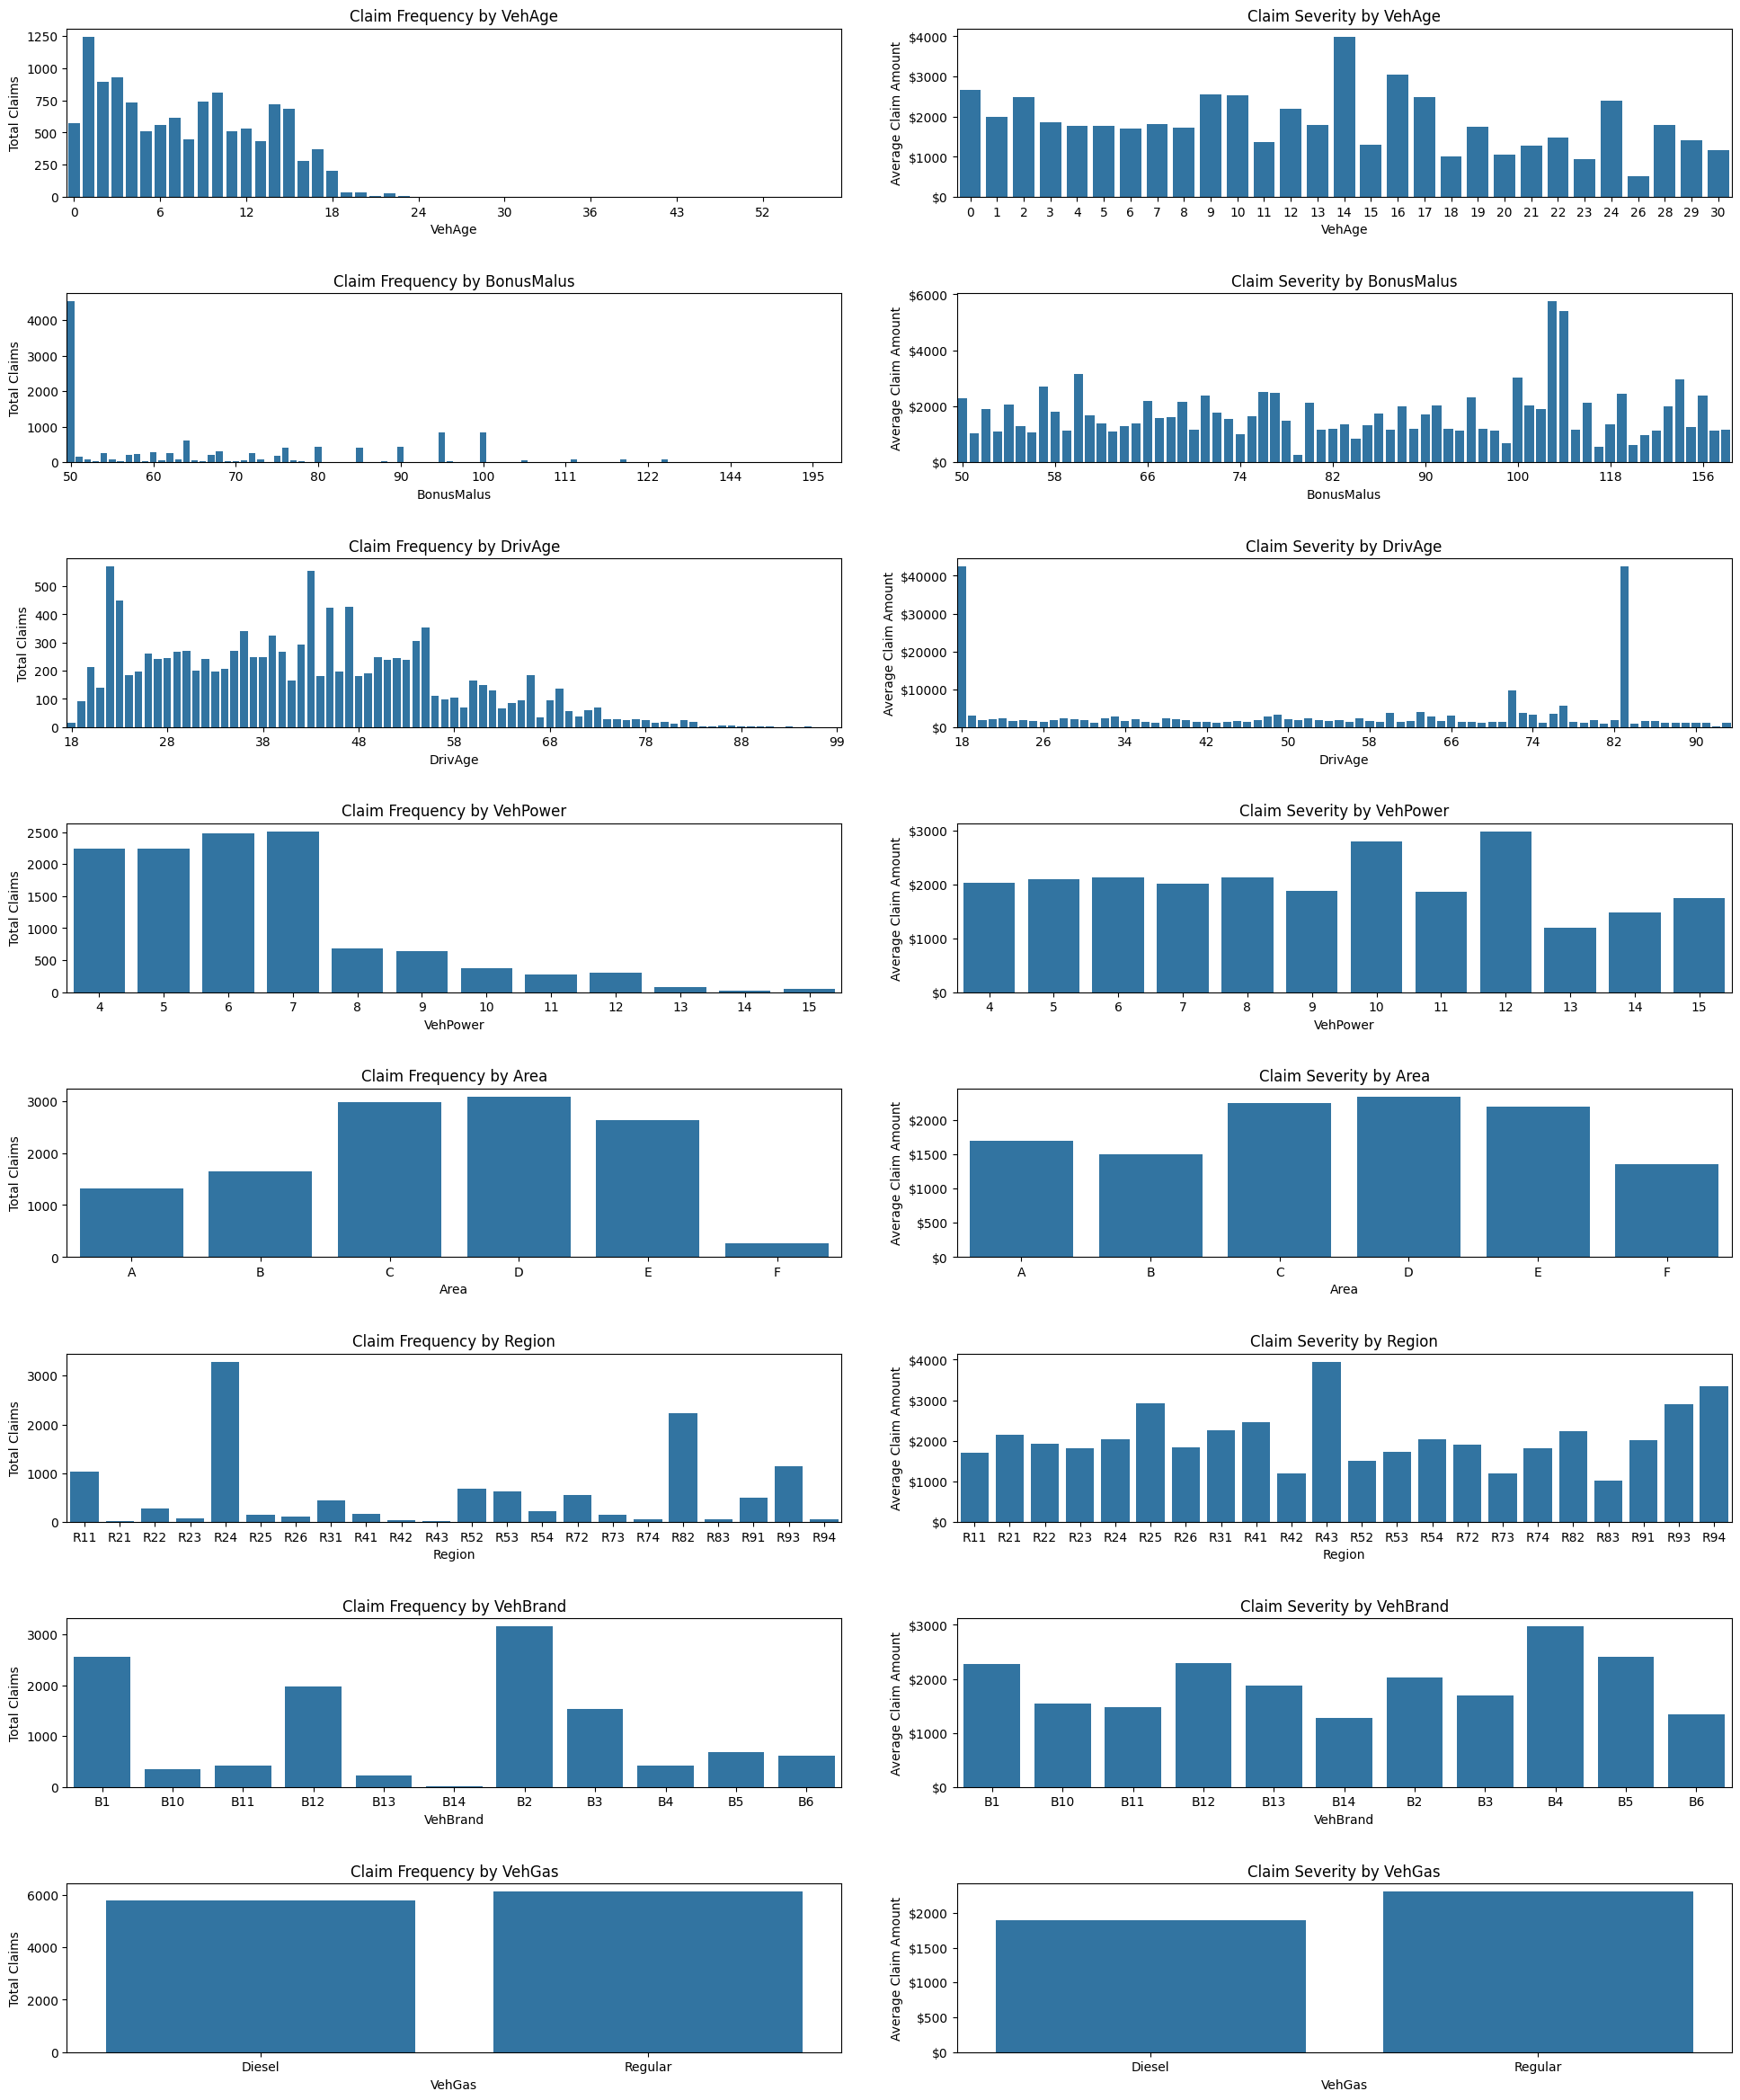

In [593]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area','Region', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 3 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

### Driver Age (Binned DrivAge)

**Overview:** The distribution of claims by driver age shows higher claim frequencies for younger and middle-aged drivers, which decreases with age.

**Statistical Summary:**
- **Mean Age:** 45.48 years
- **Standard Deviation:** 14.15 years
- **Range:** 18 to 99 years

**Justification:** Younger drivers exhibit higher risk, which could justify higher premiums pricing for these subgroups.

**Limitation:** While age is a strong predictor for risk behavior across drivers and important for our underwriting process, there are social concerns about using age as a rating variable in premium setting, which could lead to backlash.

### Vehicle Age (Binned VehAge)

**Overview:** Vehicles aged 1-3 years show the highest claim frequencies, suggesting a rapid depreciation in terms of safety or an increase in incidents due to other factors like increased usage.

**Statistical Summary:**
- **Median Vehicle Age:** 6 years
- **Interquartile Range:** 2 to 11 years

**Justification:** Newer vehicles might be associated with higher costs due to more expensive parts and repairs, influencing our premium calculations.

### Vehicle Power (Binned VehPower)

**Overview:** Lower vehicle power correlates with higher claim frequencies but not severities, indicating riskier driving behavior in lower vehicle power classes.

**Statistical Summary:**
- **Mean Power:** 6.46
- **Standard Deviation:** 2.06

**Justification:** Vehicles with lower power should potentially carry higher premiums due to an increased risk observed in our historical claims data.

### Geographical Area and Vehicle Brand

**Overview:** Claims frequencies and severities vary significantly across different areas and brands, with some brands and regions showing markedly higher risk profiles.

**Statistical Summary:**
- **Areas with Highest Claims:** Area C and D
- **Brands with Higher Claims:** Brand B1 and B2

**Justification:** Premiums could be adjusted based on the geographical risk factors and vehicle brand-specific risks.

### Geographical Regions (Region)

**Overview:** Claim frequencies and severities vary considerably across different regions, indicating geographic disparities in risk profiles.

**Statistical Summary:**
- **Regions with High Claim Frequency:** Regions R24 and R82
- **Regions with High Claim Severity:** Regions R43 and R94

**Justification:**
- **Premium Adjustments:** Fixing the insurance premiums based on regional risk assessments. Higher premiums could be justified in regions with frequent and severe claims.
- **Risk Mitigation Strategies:** Implement targeted risk mitigation strategies such as awareness campaigns, improved road safety measures, and localized driving regulations to reduce claim frequencies and severities in these high-risk regions.

### Bonus-Malus System

**Overview:** A unclear trend where higher Bonus-Malus levels sometimes correlate with increased claim severities but not frequencies, and inversely for lower Bonus-Malus scores.

**Statistical Summary:**
- **Mean Bonus-Malus:** 59.82
- **Standard Deviation:** 15.65

In [7]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Frequency,Severity
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,2.617735e+06,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887,0.119194,70.764054
std,1.643394e+06,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302,2.141210,1448.674413
min,1.500000e+01,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000,0.000000,0.000000
25%,1.156127e+06,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000,0.000000,0.000000
50%,2.271008e+06,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000,0.000000,0.000000
75%,4.044791e+06,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000,0.000000,0.000000
max,6.114324e+06,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000,365.000004,200000.000000


In [207]:
total_claims_frequency = pd.DataFrame(claims_data['Frequency'].value_counts())
total_claims_frequency

,count
Frequency,
0.000000,96335
1.000000,1247
2.000000,146
2.040816,59
4.166667,53
...,...
22.222222,1
2.597403,1
121.666668,1


In [208]:
total_claims_severity = pd.DataFrame(claims_data['Severity'].value_counts())
total_claims_severity

,count
Severity,
0.00,96335
1204.00,662
1128.12,409
1172.00,290
1128.00,96
...,...
1307.64,1
1858.81,1
741.77,1


In [583]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['Frequency'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['Severity'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1).head(3)

,Frequency,Severity
DrivAge,,
18,16.322587,210524.965
19,91.403724,78742.210
20,213.609450,90009.665


In [582]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['Frequency'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['Severity'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1).head(3)

,Frequency,Severity
VehAge,,
0,570.358022,362637.860000
1,1244.758156,512712.610000
2,896.493005,692091.993333


In [584]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['Frequency'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['Severity'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1).head(3)

,Frequency,Severity
BonusMalus,,
50,4527.854394,3.367297e+06
51,144.747215,5.606332e+04
52,66.867186,4.866783e+04


In [585]:
# Total claims by vechicle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['Frequency'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['Severity'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1).head(3)

,Frequency,Severity
VehPower,,
4,2241.808393,8.955589e+05
5,2248.298384,1.481127e+06
6,2487.080157,1.690078e+06


### Correlation between risk caracteristics

- Most of the correlations between the variables are **weak** (close to 0), indicating that there is **no strong linear relationship** between most pairs of variables. 
- The only moderate correlation is **between DrivAge and BonusMalus** (-0.480037), suggesting that as the driver's age increases, the Bonus-Malus score tends to decrease.
- **Redundancy:** These two variables are correlated, so they provide similar information to the model. Including both might not add significant value.

In [9]:
# Check for correlation between risk caracteristics (VehPower, DrivAge, BonusMalus, VehAge, Density)
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'VehAge', 'Density']].corr()

,VehPower,DrivAge,BonusMalus,VehAge,Density
VehPower,1.000000,0.028375,-0.077144,-0.006254,0.044586
DrivAge,0.028375,1.000000,-0.480037,-0.057351,-0.005337
BonusMalus,-0.077144,-0.480037,1.000000,0.084034,0.080366
VehAge,-0.006254,-0.057351,0.084034,1.000000,-0.091280
Density,0.044586,-0.005337,0.080366,-0.091280,1.000000


# 2. Risk Group Assignment Algorithm Development

**Objective:** 

The objective was to develop a risk group assignment algorithm capable of categorizing insured individuals into distinct risk classes based on observable characteristics. This classification will help in tailoring insurance premiums and policies that correspond to the risk each client presents for the auto-insurance company.

## 2.1. Methodology
The development process of the risk classification system involved several key steps, from data preprocessing to clustering and model validation.

### Data Preprocessing Categorization
Before applying the clustering model, a crucial step involves preprocessing the data to create meaningful subgroups among the insurance company's claimants based on their respective characteristics. This process not only helps in reducing noise and managing outliers in the clustering model but also enhances the interpretability of the clustering outcomes. Below, we outline the strategy for binning key continuous variables based on their distribution characteristics:

The features selected for binning include driver's age (`DrivAge`), vehicle age (`VehAge`), and vehicle power (`VehPower`). The binning process was carried out using quantile-based discretization to ensure each bin contained approximately the same number of instances, enhancing the uniformity of the data. A custom Python function was developed to automate the binning process.

The binning method described here is used for each feature in our risk classification algorithm:


In [483]:
# Function to perform quantile binning and apply it to the claims data set
def quantile_binning_and_apply(claims_data, features, n_bins, specific_bins=None):
    bin_labels_dict = {}
    for feature in features:
        # Used a specific number of bins for some features or n_bins if not specified
        bins = specific_bins.get(feature, n_bins) if specific_bins else n_bins
        bin_edges = pd.qcut(claims_data[feature], q=bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
    return bin_labels_dict

# Treatment of BonusMalus as specified in the project description 
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

<!-- Binning of Driver Age -->
In our data preprocessing, we've chosen to apply a more granular binning approach to the `DrivAge` feature compared to others like `VehAge` and `VehPower`. While the general approach assigns 10 bins to most features, `DrivAge` is assigned 20 bins. This enhanced granularity allows us to capture finer distinctions in the risk profiles associated with different age groups of drivers. 

In [589]:
# Call the function for the specified features and number of bins (10)
# Define the numbers of bins for specific features (DrivAge), to get more granularity into the bins classification
bin_labels_dict = quantile_binning_and_apply(claims_data, ['DrivAge', 'VehAge','VehPower'], 10, {'DrivAge': 20})

# Find the maximum length of the lists in the dictionary
max_length = max(len(v) for v in bin_labels_dict.values())

# Fill shorter lists with NaN values so they all have the same length
for key, value in bin_labels_dict.items():
    bin_labels_dict[key] = value + [None] * (max_length - len(value))

# Create a DataFrame from the dictionary of bin labels
df_bins = pd.DataFrame(bin_labels_dict)

# Display the resulting DataFrame
df_bins.head(3)

,Binned DrivAge,Binned VehAge,Binned VehPower
0,18.0-25.0,0.0-1.0,4.0-5.0
1,25.0-28.0,1.0-2.0,5.0-6.0
2,28.0-30.0,2.0-3.0,6.0-7.0


### Optimal Amount of Cluster (k) using the Elbow Method

The results from running the code for the Elbow method provided us with the following graph which indicates that the ideal number of clusters for the dataset is `3`, if all 100 000 policyholders are used in the model.

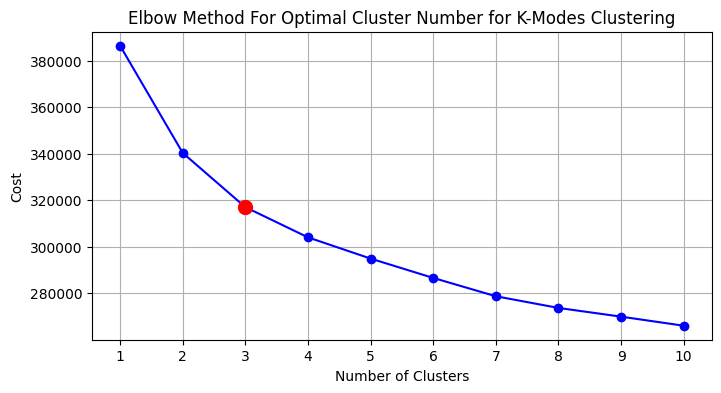

In [ ]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']
features = ['DrivAge', 'VehAge','VehPower']

# Prepare data for one-hot encoding
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering 
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array before applying K-Modes 
data_matrix = df_categorical.to_numpy()

# Apply the elbow method to find the optimal number of clusters for K-Modes clustering method
cost = []
K = range(1, 11)  # Range of clusters to try for the elbow method 
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Cluster Number for K-Modes Clustering')
plt.xticks(K)
plt.grid(True)

# Highlight the optimal number of clusters (3) in red 
optimal_k = 3
plt.plot(optimal_k, cost[optimal_k - 1], marker='o', markersize=10, color='r')
plt.show()

### Implementation of `K-Modes` Clustering Method

It's crucial to select an appropriate model for clustering our data. After testing various clustering methods such as `DBSCAN` (unsupervised algorithm), `K-means`, `K-prototype`, and `K-Medoids`, we decided to employ the `K-Modes` clustering method, which is particularly suitable for our categorical data. The data was prepared by combining previously binned features with additional categorical variables such as `Area` and `VehBrand`, to enrich our clustering analysis. The following Python code snippet illustrates the implementation of the K-Modes clustering method:


For more details, we applied the K-Modes clustering algorithm as follows:

1. **Algorithm Initialization:**
   We initialized the K-Modes algorithm with a specified number of clusters (K=3).

2. **Model Fitting:**
   The K-Modes model was fitted to the one-hot encoded categorical matrix derived from our data. This step involves the iterative relocation of data points to the nearest clusters and recalculating the modes of each cluster.

3. **Cluster Assignment:**
   Then the clustering model assigned each data point to one of the three clusters based on the minimal dissimilarity, measured by the Hamming distance, which counts the number of differing characteristics between data points and the cluster modes.


In [557]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus'] # See if we add more columns to improve the clustering results 

def apply_k_modes_clustering(claims_data, features, additional_categorical_columns, n_clusters, random_state):
    """
    Apply K-Modes clustering on categorical data.
    
    Parameters:
        claims_data (DataFrame): The DataFrame containing the claims data.
        features (list): List of features to be binned and included in the clustering.
        additional_categorical_columns (list): List of additional categorical columns to include.
        n_clusters (int, optional): The number of clusters to form. Defaults to 3.
        random_state (int, optional): Random state for reproducibility. Defaults to 42.
    
    Returns:
        DataFrame: The DataFrame with an additional column 'Risk Cluster K-Mode' indicating the cluster assignment.
    """
    # Combine binned features and additional categorical columns
    categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
    
    # Convert categorical columns to category type
    for col in categorical_columns:
        claims_data[col] = claims_data[col].astype('category')
    
    # Use only categorical columns for clustering
    df_categorical = claims_data[categorical_columns]
    
    # Convert the DataFrame to a numpy array
    data_matrix = df_categorical.to_numpy()
    
    # Apply K-Modes clustering
    kmodes = KModes(n_clusters=n_clusters, random_state=random_state)
    clusters = kmodes.fit_predict(data_matrix)
    
    # Store the result in 'Risk Cluster K-Mode' column
    claims_data['Risk Cluster K-Mode'] = clusters
    
    return claims_data

# Assuming your DataFrame is named claims_data
updated_claims_data = apply_k_modes_clustering(
    claims_data=claims_data,
    features=features,
    additional_categorical_columns=additional_categorical_columns,
    n_clusters=3,  # Number of clusters you want
    random_state=42  # Seed for reproducibility
)


### Validate the clusters using `CatBoostClassifier`

Following the identification of risk clusters using the K-Modes clustering method, the next step of our approach for risk classification involves employing a CatBoost classifier to validate the three prior clusters identified. 

CatBoost is an algorithm for gradient boosting on decision trees, designed to work well with categorical data. We particularly favored this supervised machine learning algorithm for its efficiency, accuracy, and simplicity to handling categorical data.

The hyperparameters -  `iterations`, `learning rate`, `depth` and `test size` - were optimized using `GridSearchCV`, a systematic method for parameter tuning through cross-validation.

The `CatBoost classifier` was then setup and train using these optimized parameters and the pre defined clusters from the K-Modes method:

In [ ]:
# Extract labels from the 'Risk Cluster' column of K-Modes clustering
labels = claims_data['Risk Cluster K-Mode']

# Identify categorical feature indices for CatBoost model to use 
cat_features_indices = [df_categorical.columns.get_loc(col) for col in categorical_columns]

# Split the data into training and testing sets (20% test data) and use the rest as training data (20% was the best split ratio based on GridSearchCV results optimization run)
X_train, X_test, y_train, y_test = train_test_split(df_categorical, labels, test_size=0.2, random_state=42)

# Train a CatBoost classifier with adjusted parameters
model = CatBoostClassifier(
    iterations=500,          # Number of iterations are based on GridSearchCV results optimization run to find the best parameters 
    learning_rate=0.1,      # Number of iterations are based on GridSearchCV results optimization run to find the best parameters
    depth=10,                 # Depth of the tree are based on GridSearchCV results optimization run to find the best parameters
    random_seed=42,          # Random seed for reproducibility
    cat_features=cat_features_indices # Categorical feature indices for CatBoost model to use 
    )
model.fit(X_train, y_train)

# Predict on the entire dataset to get the predicted risk clusters (Validation) 
claims_data['Predicted Risk Cluster'] = model.predict(df_categorical)

0:	learn: 0.9590885	total: 55.6ms	remaining: 27.7s
1:	learn: 0.8522171	total: 102ms	remaining: 25.3s
2:	learn: 0.7631748	total: 148ms	remaining: 24.5s
3:	learn: 0.6881025	total: 193ms	remaining: 23.9s
4:	learn: 0.6271395	total: 238ms	remaining: 23.6s
5:	learn: 0.5744777	total: 282ms	remaining: 23.2s
6:	learn: 0.5302366	total: 324ms	remaining: 22.8s
7:	learn: 0.4912163	total: 368ms	remaining: 22.6s
8:	learn: 0.4535651	total: 412ms	remaining: 22.4s
9:	learn: 0.4194899	total: 454ms	remaining: 22.3s
10:	learn: 0.3890516	total: 496ms	remaining: 22s
11:	learn: 0.3618022	total: 540ms	remaining: 22s
12:	learn: 0.3339199	total: 583ms	remaining: 21.8s
13:	learn: 0.3095599	total: 622ms	remaining: 21.6s
14:	learn: 0.2900302	total: 665ms	remaining: 21.5s
15:	learn: 0.2721421	total: 708ms	remaining: 21.4s
16:	learn: 0.2551998	total: 751ms	remaining: 21.3s
17:	learn: 0.2394547	total: 792ms	remaining: 21.2s
18:	learn: 0.2250239	total: 841ms	remaining: 21.3s
19:	learn: 0.2109746	total: 885ms	remaining:

### Model Evaluation

After training, the model's performance was assessed using a cross-validation procedure. This validation is crucial for ensuring that the risk categories defined by the K-Modes are not only statistically sound but also predictive.

The cross-validation results yield high scores across five folds: `[1.0, 1.0, 1.0, 0.99975, 0.99995]`. The mean cross-validation score, approximately `0.99994`, highlights the model's consistency and accuracy across different subsets of the original binned categories dataset `df_categorical`.

The significance of these results extends to the initial risk categorization performed using the K-Modes clustering method. The alignment of the CatBoost model's predictions with the K-Modes derived clusters supports the accuracy of the initial risk groups identified.


In [49]:
# Perform cross-validation - takes too long to run, was simply done for validation purposes
#cv_scores = cross_val_score(model, df_categorical, labels, cv=5, scoring='accuracy')

# Print cross-validation scores
#print("Cross-validation scores:", cv_scores)
#print("Mean cross-validation score:", cv_scores.mean())

# Mean cross-validation score = 0.9999

0:	learn: 0.9668572	total: 48.7ms	remaining: 24.3s
1:	learn: 0.8694815	total: 92.8ms	remaining: 23.1s
2:	learn: 0.7872921	total: 139ms	remaining: 23s
3:	learn: 0.7095477	total: 182ms	remaining: 22.5s
4:	learn: 0.6436884	total: 226ms	remaining: 22.4s
5:	learn: 0.5900515	total: 269ms	remaining: 22.2s
6:	learn: 0.5447845	total: 313ms	remaining: 22s
7:	learn: 0.5039698	total: 355ms	remaining: 21.8s
8:	learn: 0.4679559	total: 398ms	remaining: 21.7s
9:	learn: 0.4360790	total: 439ms	remaining: 21.5s
10:	learn: 0.4032829	total: 483ms	remaining: 21.5s
11:	learn: 0.3731734	total: 527ms	remaining: 21.4s
12:	learn: 0.3497200	total: 571ms	remaining: 21.4s
13:	learn: 0.3238842	total: 613ms	remaining: 21.3s
14:	learn: 0.3017919	total: 657ms	remaining: 21.2s
15:	learn: 0.2823201	total: 699ms	remaining: 21.1s
16:	learn: 0.2642639	total: 741ms	remaining: 21s
17:	learn: 0.2464323	total: 781ms	remaining: 20.9s
18:	learn: 0.2315482	total: 823ms	remaining: 20.8s
19:	learn: 0.2170596	total: 867ms	remaining: 

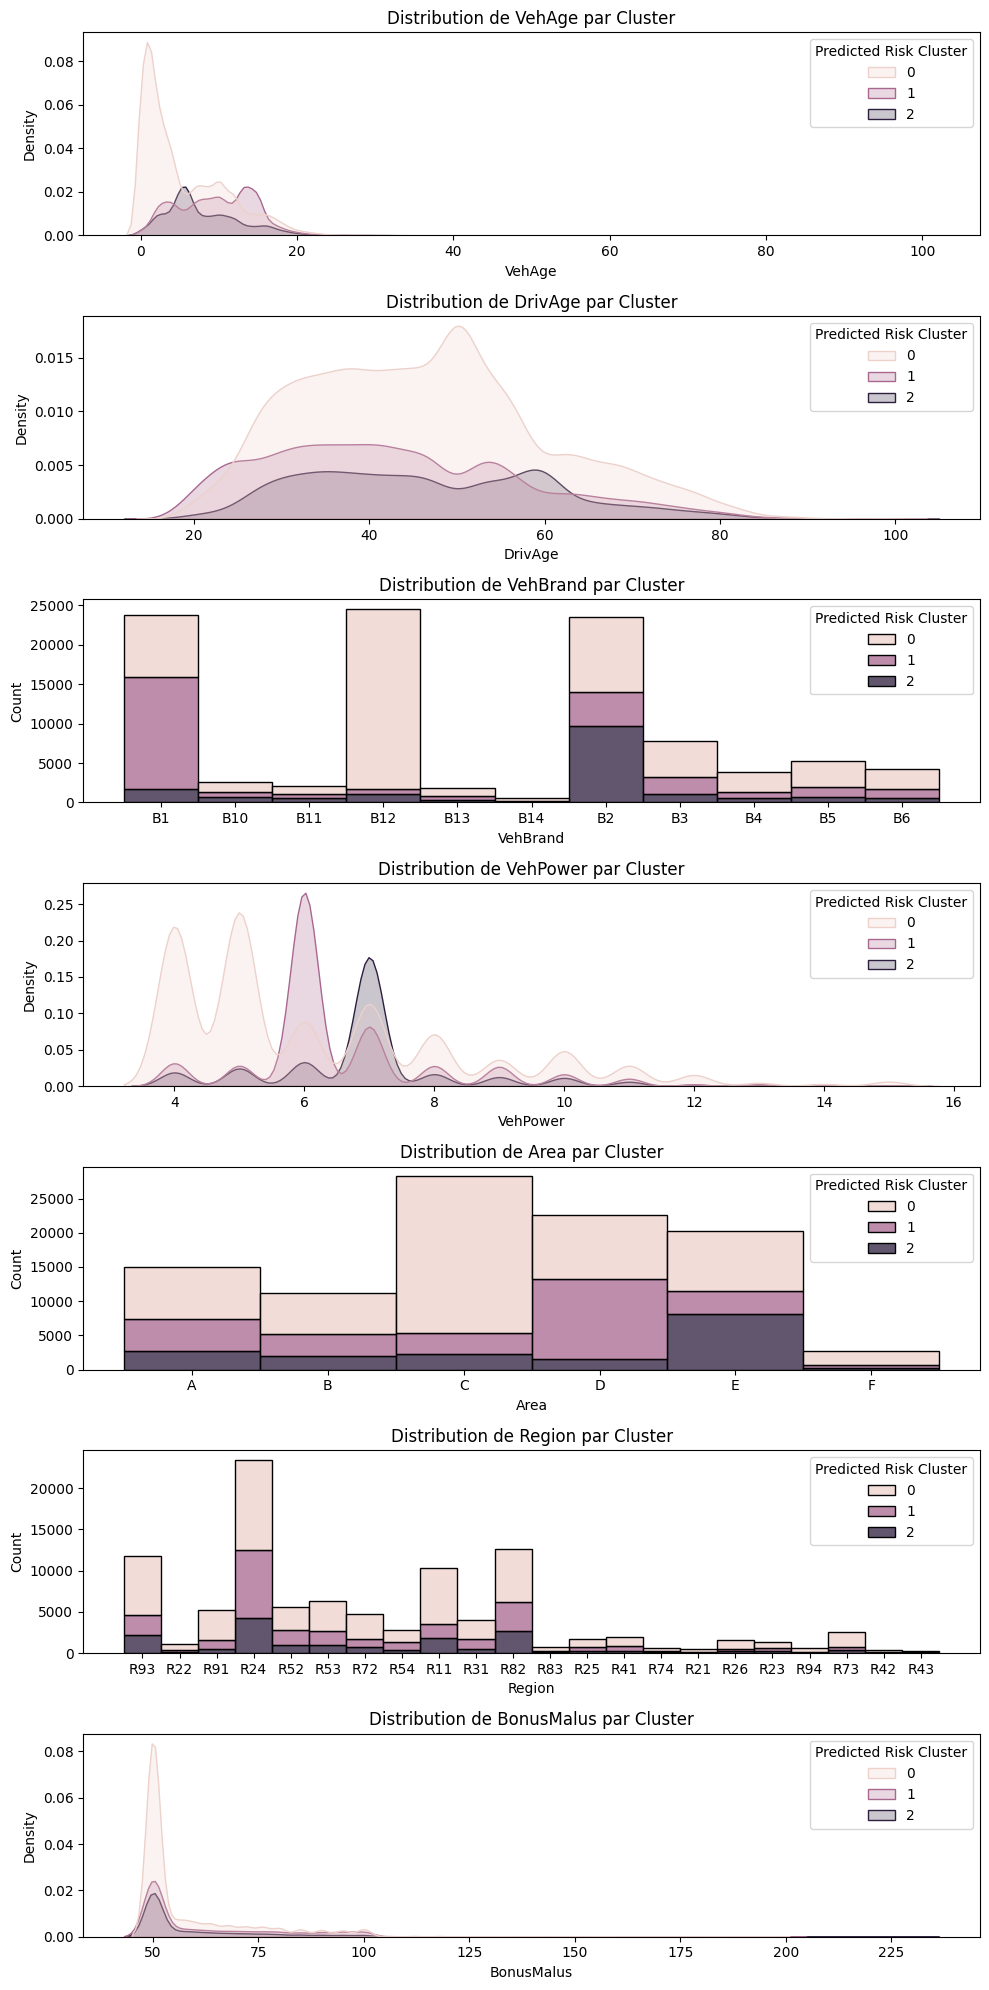

In [35]:
# Define the variables to plot 
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area', 'Region', 'BonusMalus']
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 20))

# Plot the distribution of variables by predicted risk cluster
# We use sns.histplot for categorical variables and sns.kdeplot for numerical variables.
# This allows us to visualize how different variables are distributed across the predicted risk clusters.
for i, var in enumerate(variables):
    assert var in claims_data.columns, f"La colonne {var} est manquante dans claims_data"
    if claims_data[var].dtype.name == 'category' or claims_data[var].dtype.name == 'object':
        sns.histplot(data=claims_data, x=var, hue='Predicted Risk Cluster', multiple="stack", ax=axes[i])
    else:
        sns.kdeplot(data=claims_data, x=var, hue='Predicted Risk Cluster', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var} par Cluster')

# Adjust the layout of the subplots to avoid overlap 
plt.tight_layout()
plt.show()

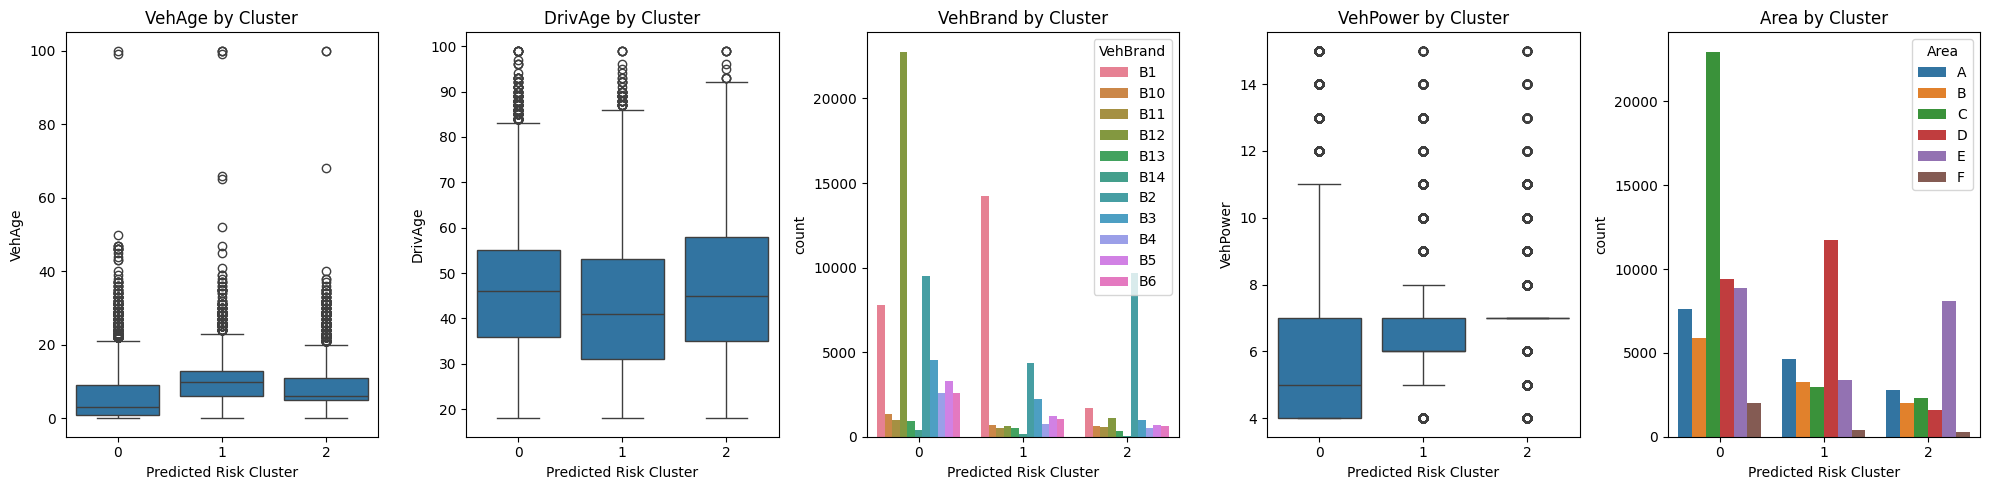

In [31]:
# Define the variables to plot
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(1, len(variables), figsize=(20, 5))

# Plot the distribution of variables by predicted risk cluster
# Use sns.boxplot for numerical variables and sns.countplot for categorical variables to visualize the distribution of variables by predicted risk clusters.
for i, var in enumerate(variables):
    assert var in claims_data.columns, f"The column {var} is missing in claims_data"
    if claims_data[var].dtype.name == 'category' or claims_data[var].dtype.name == 'object':
        sns.countplot(data=claims_data, x='Predicted Risk Cluster', hue=var, ax=axes[i])
    else:
        sns.boxplot(data=claims_data, x='Predicted Risk Cluster', y=var, ax=axes[i])
    axes[i].set_title(f'{var} by Cluster')

# Adjust the layout of the subplots to avoid overlap
plt.tight_layout()
plt.show()

- These visualizations help in understanding how different features influence the predicted risk clusters and in evaluating the performance of the clustering model.

### Cluster Evaluation using Silhouette Score

The `silhouette score` is a metric used to evaluate the quality of clusters in a clustering model. It helps determine whether objects within a cluster are well-grouped (intra-cluster cohesion) and adequately separated from other clusters (inter-cluster separation).

Before calculating the silhouette score, categorical data must be transformed into a numerical format so that clustering algorithms can process it properly, typically using "One-Hot" encoding. This transformation allows for the calculation of distances between categorical points and thus evaluates their cluster membership.

The overall silhouette score is the average of the individual scores for all points in each clusters, calculated using the following code:



In [297]:
# Enconding categorical data to evaluate the clusters - also a bit long 
df_categorical_encoded = OneHotEncoder().fit_transform(df_categorical)
silhouette = silhouette_score(df_categorical_encoded, claims_data['Predicted Risk Cluster'])
davies_bouldin = davies_bouldin_score(df_categorical_encoded.toarray(), claims_data['Predicted Risk Cluster'])

print(f"Silhouette Score: {silhouette}")
print(f"Davies Bouldin Score: {davies_bouldin}")

Silhouette Score: 0.04166128773615188
Davies Bouldin Score: 4.020328720316979


Our clustering approach utilized the K-Modes method, which yielded a silhouette score of `0.04`. This low score suggested minimal distinction between the identified risk clusters. Overall, these scores indicate that the k-modes clustering may not have formed perfectly well-defined and distinct clusters in this dataset based on statistical measurement. 

However, we will see that we have selected the k-modes clustering method for its simplicity to implement and understand. This choice is a concession we made to balance ease of use and interpretability with the clustering performance...

### Exploration of Alternative Clustering Techniques

In our quest to improve clustering performance, we experimented with a series of advanced analytical techniques:
1. **`DBSCAN` Algorithm:** Initially used to identify dense clusters of data.
2. **Dimensionality Reduction via `PCA`:** Employed to simplify the data structure after DBSCAN produced over 10,000 clusters.
3. **`KMeans` Algorithm:** Applied to the transformed dataset to define clearer, fewer clusters, improving comprehension of the risk clusters.

This approach led to a higher silhouette score of approximately `0.3`, indicating better separation between clusters compared to the K-Modes method. However, the increased complexity of this multi-step process introduced significant challenges:
- **Complexity:** Computationally intensive and complex, requiring careful tuning of parameters.
- **Interpretability:** Resulting clusters were statistically distinct but less meaningful in practical terms, exhibiting overlap in key risk-defining characteristics such as Vehicle Age, Vehicle Brand, and Vehicle Power.

These overlaps reduced the effectiveness of the clusters in distinctly categorizing risks, crucial for practical applications in the underwriting process.

### Rationale for Selecting K-Modes Clustering

Given the complexities and the ambiguous nature of the risk clusters obtained from the alternative method, we opted to continue with the `K-Modes` clustering approach due to:
- **Simplicity:** K-Modes is computationally less demanding and easier to implement.
- **Actionability:** Clusters generated are more interpretable and directly applicable to real-world risk assessment tasks.
- **Practical Relevance:** Despite its lower silhouette score, K-Modes provides a more straightforward interpretation of the data, facilitating easier decision-making in underwriting activities.
- **Additional Criteria:** [To be added from lecture notes]


## 2.2. Results of Risk Categorization and Analysis of Clusters

Analysis of these clusters revealed:

 - That our risk cluster are well diversified and defined, meaning they do not exhibited overlap in key risk-defining characteristics, such as in `Driver Age`, `Vehicle Age`, `Vehicle Brand`, `Vehicle Power` and `Area`. 

 - The `Bonus/Malus` variable does not show a significant impact on the clustering process. Also, it is highly correlated with Driver Age (refer to the correlation matrix at the beginning of the code). In that case, this is not a variable we will retain in our final risk classification algorithm.

 - That `Cluster 1` tend to be the most riskiest cluster in our risk classification process, resulting in higher claims frequencies, followed by `Cluster 0` and `Cluster 2`. It has the biggest impact on overall risk from the point of view of the insurer, based on total losses from the data on claims frequency and severity.

 - The analysis using the CatBoost `model.get_feature_importance()` to extract feature importance confirms our previous intuition. All variables, except for the `Bonus/Malus` variable, show significant importance in predicting the cluster labels. This further supports our decision to exclude the `Bonus/Malus` variable from the final risk classification process, as it does not contribute meaningfully.

In [487]:
# The table below summarizes the characteristics of each risk cluster identified by the K-Modes clustering algorithm. Each row represents a distinct cluster, 
# with the most frequent values (modes) for various features, as well as the count of data points in each cluster.
# Count the number of data points in each cluster predicted by the CatBoost model
predicted_cluster_counts = claims_data['Risk Cluster K-Mode'].value_counts()
predicted_cluster_counts

# Function to get the most frequent values (mode) for each feature in each cluster
def get_cluster_modes(df, cluster_col, feature_cols):
    # Group by the cluster column and calculate the mode for each feature
    cluster_modes = df.groupby(cluster_col)[feature_cols].agg(lambda x: x.mode().iloc[0])
    # Add a column for the count of each cluster
    cluster_modes['Count'] = df[cluster_col].value_counts()
    return cluster_modes

# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(claims_data,'Risk Cluster K-Mode', feature_cols)

# Display common characteristics for each cluster
cluster_modes

,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus,Count
Risk Cluster K-Mode,,,,,,,
0,48.0-51.0,0.0-1.0,4.0-5.0,C,B12,Bonus,56680
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,Bonus,26313
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,Bonus,17007


**`Cluster 0`:** Characterized by middle-aged drivers (48-51 years) in relatively new vehicles (0-1 year old) with moderate vehicle power (4-5). Predominantly located in Area C with vehicles from Brand B12. This cluster has the highest count, suggesting it is the most common risk profile among our data.

**`Cluster 1`:** Includes younger drivers (18-25 years) in older vehicles (12-15 years old) with slightly higher vehicle power (5-6). This group is concentrated in Area D with vehicles from Brand B1. The risk profile here involve higher risk due to the combination of young drivers and older vehicles.

**`Cluster 2`:** Comprises older drivers (57-61 years) in vehicles of moderate age (4-6 years old) and higher power (6-7). Located in Area E with vehicles from Brand B2. This cluster represent a lower risk due to the age and experience of the drivers, despite the increased vehicle power.

These clusters help in tailoring risk management strategies and insurance premiums more accurately by identifying patterns and commonalities within the policyholders of the insurance company.

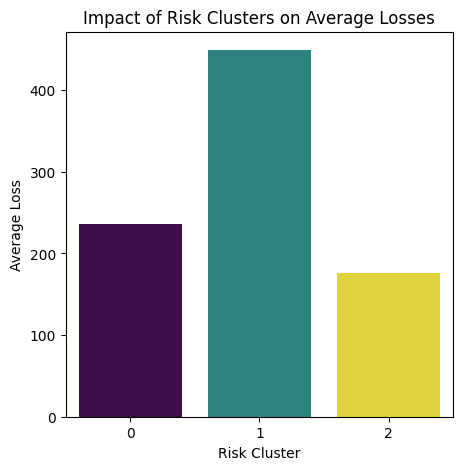

In [590]:
# Create a new column for total losses by multiplying frequency and severity of claims 
claims_data['Total Loss'] = claims_data['Frequency'] * claims_data['Severity']

# Calculate the mean total losses for each predicted risk cluster
cluster_total_losses = claims_data.groupby('Risk Cluster K-Mode')['Total Loss'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on total losses to see the riskiest cluster and the 'safest' cluster
plt.figure(figsize=(5, 5))
bar_plot = sns.barplot(data=cluster_total_losses, x='Risk Cluster K-Mode', y='Total Loss', hue='Risk Cluster K-Mode', palette='viridis', dodge=False, legend=False)

plt.title('Impact of Risk Clusters on Average Losses')
plt.xlabel('Risk Cluster')
plt.ylabel('Average Loss')
plt.show()

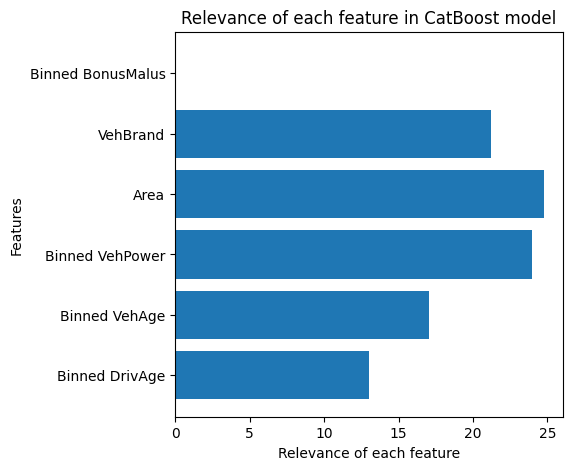

In [591]:
# CatBoost provides built-in methods to extract feature importance, which can offer insights into what features are driving the distinctions between clusters.
# Obtain which characteristics are the most important for predicting the cluster labels.
feature_importances = model.get_feature_importance()
feature_names = df_categorical.columns

# Create a bar plot to visualize the importance of each characteristics in the CatBoost model
plt.figure(figsize=(5, 5))
plt.barh(feature_names, feature_importances)
plt.xlabel('Relevance of each feature')
plt.ylabel('Features')
plt.title('Relevance of each feature in CatBoost model')
plt.show()

In [344]:
# Create DataFrames based on clusters for further analysis (premium calculation, etc.)
df_cluster_0 = claims_data[claims_data['Risk Cluster K-Mode'] == 0].copy()
df_cluster_1 = claims_data[claims_data['Risk Cluster K-Mode'] == 1].copy()
df_cluster_2 = claims_data[claims_data['Risk Cluster K-Mode'] == 2].copy()

# 3. Predicting total losses

In this section, we seeked to estimate the distribution of total losses for the next year. We first created formulas for the AIC and BIC criteria, then tested the Poisson, Binomial and Negative Binomial distributions for the frequency of losses (i.e. how often we have claims), and the Log-normal, Pareto and Gamma distributions for the severity of losses (i.e. how large the claims are). The lower AIC and BIC values informs us on the distribution that fits best. 

We first conducted this analysis on the total distribution. Then, in order to ensure that each cluster has the same distribution as our entire data set, we conducted the same analysis per cluster. This methodology, while perhaps not necessary, allowed us to be the most precise possible, erasing any doubts on the distribution fit of each cluster.

## 3.1. Testing distributions

*AIC and BIC criterias*

In [488]:
# Functions to calculate AIC and BIC as measures of the goodness of fit for different distribution models
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

*Function to test distributions*

In [489]:
def distrib_test(x, dist, params, title, dist_type):
    """ Test distribution and calculate AIC and BIC. """
    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

#### Total claims

In [491]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['Severity'] > 0]['Severity']

*Frequency*

In [492]:
# Poisson Distribution Fitting for Claim Frequency
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency
n_trials = 1  # Number of trials (1 for each policyholder) 
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency
mean_claims = np.mean(claim_counts)
var_claims = np.var(claim_counts, ddof=1) # Use ddof=1 for sample variance 
if var_claims > mean_claims:
    r_negbin = (mean_claims ** 2) / (var_claims - mean_claims)
    p_negbin = r_negbin / (r_negbin + mean_claims)
    params_negbin = [r_negbin, p_negbin]
    
    # Fit check with our distribution testing function
    distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 133832.56732566294
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09246842703
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.78647043131
BIC for Fit with Negative Binomial Distribution: 120219.81232136126


**Results**

The Negative Binomial Distribution gives the lowest values for the AIC and BIC criteria. This is the best distribution fit for the frequency of losses.

*Severity*

In [530]:
# Log-normal fitting for severity 
shape, loc, scale = lognorm.fit(non_zero_claims)
params_lognorm = [shape, loc, scale]
distrib_test(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc_pareto, scale_pareto = pareto.fit(non_zero_claims)  
params_pareto = [b, loc_pareto, scale_pareto]
distrib_test(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc_gamma, beta = gamma.fit(non_zero_claims)  
params_gamma = [alpha, loc_gamma, beta]
distrib_test(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')


AIC for Fit with Log-normal Distribution: 61011.03355955744
BIC for Fit with Log-normal Distribution: 61029.653310400405
AIC for Fit with Pareto Distribution: 61251.71150028282
BIC for Fit with Pareto Distribution: 61270.33125112578
AIC for Fit with Gamma Distribution: 167970.14982245426
BIC for Fit with Gamma Distribution: 167988.76957329724


**Results**

The Log-normal Distribution gives the lowest values for the AIC and BIC criteria. This is the best distribution fit for the severity of losses.

**Cluster 0**

In [494]:
# Filter out zero claim amounts for severity 
claim_counts_0 = df_cluster_0['Frequency']
non_zero_claims_0 = df_cluster_0[df_cluster_0['Severity'] > 0]['Severity']

*Frequency*

In [495]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 0)
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 0)
n_trials_0 = 1  # Number of trials (1 for each policyholder)
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 0)
mean_claims_0 = np.mean(claim_counts_0)
var_claims_0 = np.var(claim_counts_0, ddof=1)  # Use ddof=1 for sample variance
if var_claims_0 > mean_claims_0:
    r_negbin_0 = (mean_claims_0 ** 2) / (var_claims_0 - mean_claims_0)
    p_negbin_0 = r_negbin_0 / (r_negbin_0 + mean_claims_0)
    params_negbin_0 = [r_negbin_0, p_negbin_0]

    # Fit check with our distribution testing function
    distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')


AIC for Fit with Poisson Distribution: 69317.96509096696
BIC for Fit with Poisson Distribution: 69326.91026766076
AIC for Fit with Binomial Distribution: 72651.72826332867
BIC for Fit with Binomial Distribution: 72669.61861671628
AIC for Fit with Negative Binomial Distribution: 61699.27596738552
BIC for Fit with Negative Binomial Distribution: 61717.166320773125


*Severity*

In [531]:
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0)
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_test(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_0, loc_pareto_0, scale_pareto_0 = pareto.fit(non_zero_claims_0)  
params_pareto_0 = [b_pareto_0, loc_pareto_0, scale_pareto_0]
distrib_test(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_gamme_0, beta_0 = gamma.fit(non_zero_claims_0)  
params_gamma_0 = [alpha_0, loc_gamme_0, beta_0]
distrib_test(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 30071.413377883982
BIC for Fit with Log-normal Distribution: 30087.908325496282
AIC for Fit with Pareto Distribution: 30207.66167850583
BIC for Fit with Pareto Distribution: 30224.15662611813
AIC for Fit with Gamma Distribution: 82775.57817446705
BIC for Fit with Gamma Distribution: 82792.07312207935


**Cluster 1**

In [497]:
# Filter out zero claim amounts for severity 
claim_counts_1 = df_cluster_1['Frequency']
non_zero_claims_1 = df_cluster_1[df_cluster_1['Severity'] > 0]['Severity']

*Frequency*

In [498]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 1)
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 1)
n_trials_1 = 1  # Number of trials (1 for each policyholder)
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 1)
mean_claims_1 = np.mean(claim_counts_1)
var_claims_1 = np.var(claim_counts_1, ddof=1)  # Use ddof=1 for sample variance
if var_claims_1 > mean_claims_1:
    r_negbin_1 = (mean_claims_1 ** 2) / (var_claims_1 - mean_claims_1)
    p_negbin_1 = r_negbin_1 / (r_negbin_1 + mean_claims_1)
    params_negbin_1 = [r_negbin_1, p_negbin_1]

    # Fit check with our distribution testing function
    distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 41980.71341737464
BIC for Fit with Poisson Distribution: 41988.89123576726
AIC for Fit with Binomial Distribution: 44396.52139047038
BIC for Fit with Binomial Distribution: 44412.877027255614
AIC for Fit with Negative Binomial Distribution: 37367.02169802738
BIC for Fit with Negative Binomial Distribution: 37383.37733481262


*Severity*

In [532]:
# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1)
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_test(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_1, loc_pareto_1, scale_pareto_1 = pareto.fit(non_zero_claims_1)  
params_pareto_1 = [b_pareto_1, loc_pareto_1, scale_pareto_1]
distrib_test(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_gamma_1, beta_1 = gamma.fit(non_zero_claims_1) 
params_gamma_1 = [alpha_1, loc_gamma_1, beta_1]
distrib_test(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 19324.554551397487
BIC for Fit with Log-normal Distribution: 19339.712714545185
AIC for Fit with Pareto Distribution: 19403.095097762525
BIC for Fit with Pareto Distribution: 19418.253260910224
AIC for Fit with Gamma Distribution: 53015.516666628304
BIC for Fit with Gamma Distribution: 53030.674829776


**Cluster 2**

In [500]:
# Filter out zero claim amounts for severity 
claim_counts_2 = df_cluster_2['Frequency']
non_zero_claims_2 = df_cluster_2[df_cluster_2['Severity'] > 0]['Severity']

*Frequency*

In [501]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 2)
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 2)
n_trials_2 = 1  # Number of trials (1 for each policyholder)
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 2)
mean_claims_2 = np.mean(claim_counts_2)
var_claims_2 = np.var(claim_counts_2, ddof=1)  # Use ddof=1 for sample variance
if var_claims_2 > mean_claims_2:
    r_negbin_2 = (mean_claims_2 ** 2) / (var_claims_2 - mean_claims_2)
    p_negbin_2 = r_negbin_2 / (r_negbin_2 + mean_claims_2)
    params_negbin_2 = [r_negbin_2, p_negbin_2]

    # Fit check with our distribution testing function
    distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 22518.747894799446
BIC for Fit with Poisson Distribution: 22526.489275102438
AIC for Fit with Binomial Distribution: 24085.23869630995
BIC for Fit with Binomial Distribution: 24100.721456915933
AIC for Fit with Negative Binomial Distribution: 20920.801717520935
BIC for Fit with Negative Binomial Distribution: 20936.28447812692


*Severity*

In [533]:
# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2)
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_test(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_2, loc_pareto_2, scale_pareto_2 = pareto.fit(non_zero_claims_2) 
params_pareto_2 = [b_pareto_2, loc_pareto_2, scale_pareto_2]
distrib_test(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_gamma_2, beta_2 = gamma.fit(non_zero_claims_2) 
params_gamma_2 = [alpha_2, loc_gamma_2, beta_2]
distrib_test(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 11618.868614209274
BIC for Fit with Log-normal Distribution: 11632.538949277749
AIC for Fit with Pareto Distribution: 11633.201286699441
BIC for Fit with Pareto Distribution: 11646.871621767916
AIC for Fit with Gamma Distribution: 32192.25048578799
BIC for Fit with Gamma Distribution: 32205.920820856463


**Results**

**For each cluster**, the Negative Binomial distribution gives the lowest AIC and BIC criteria for the frequency of losses, and the Log-normal distribution gives the lowest values for the severity of losses, thus giving us the same results as for total losses. However, it's interesting to note that for the severity of losses, the Pareto and Log-normal fits give AIC and BIC criteria that are rather close. To push our analysis further, we could conduct more sophisticated distribution tests to investigate more.

# 4. Premium determination

Now that the distributions are known, we can proceed to compute the premiums for the next year. To do so, we first need to know the total losses for the next year, which we have done using a monte carlo simulation. We then computed the premiums for total claims and for each cluster, alwhile ensuring that the probability of observing claims that are larger than our premiums does not exceed a threshold of 0.5%.

## 4.1 Monte carlo simulation for total losses

In [546]:
# Monte carlo simulation for ALL CLAIMS (Entire Data Set)

np.random.seed(23) # Set seed for reproducibility

# Parameters
n_simulations = 100
n_policies = len(claims_data)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs = []

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Create a severity matrix for policies with claims
    max_claim = frequency.max()  # Max number of claims across policies 
    severity_matrix = np.zeros((n_policies, max_claim))
    
    # Generate severities per policy based on the number of claims (frequency)
    for policy_idx in range(n_policies):
        claim_count = frequency[policy_idx]
        if claim_count > 0:
            severity_matrix[policy_idx, :claim_count] = lognorm.rvs(
                shape, loc=0, scale=scale, size=claim_count
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity = np.sum(severity_matrix, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Premium_per_policy': Total_claim_severity,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs.append(temp_df)

# Concatenate all temporary DataFrames at once for better performance
simulation_results = pd.concat(simulation_dfs, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation = simulation_results.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium = premium_per_simulation.mean()
print(f"The premium for the total loss distribution is: {average_premium:.2f}$")


The premium for the total loss distribution is: 200.95$


### Calculation of adjusted premium

Here, we compute the premium that respects the 0.5% condition. We also compute a simple hit measure, that validates that the premium respects the condition.

In [547]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium = scoreatpercentile(simulation_results['Premium_per_policy'], 99.5)

# Output the adjusted premium
print(f"Adjusted premium for total losses is: {adjusted_premium:.2f}$")

# Compute hit measure : 1 if Premium_per_policy > adjusted_premium_0, otherwise 0
simulation_results['Hit_Test'] = simulation_results['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium else 0)

# Calculate the percentage of hits
total_hits = simulation_results['Hit_Test'].sum()
total_records = len(simulation_results)
hit_percentage = (total_hits / total_records) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage))

Adjusted premium for total losses is: 8561.26$
Percentage of Hits (Total claims > adjusted premium): 0.50%


## 4.2 Monte carlo simulation per cluster

*Cluster 0*

In [542]:
# Monte carlo simulation for cluster 0

np.random.seed(24) # Set seed for reproducibility

# Parameters
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_0 = []

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Create a severity matrix for policies with claims
    max_claim_0 = frequency_0.max()  # Max number of claims across policies for Cluster 0
    severity_matrix_0 = np.zeros((n_policies_0, max_claim_0))
    
    # Generate severities per policy based on the number of claims (frequency_0)
    for policy_idx in range(n_policies_0):
        claim_count_0 = frequency_0[policy_idx]
        if claim_count_0 > 0:
            severity_matrix_0[policy_idx, :claim_count_0] = lognorm.rvs(
                shape_0, loc=0, scale=scale_0, size=claim_count_0
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_0 = np.sum(severity_matrix_0, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency': frequency_0,
        'Premium_per_policy': Total_claim_severity_0,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_0.append(temp_df_0)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_0 = pd.concat(simulation_dfs_0, ignore_index=True)

# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_0 = simulation_results_0.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_0 = (premium_per_simulation_0.mean()).iloc[1] 

print(f"The premium for the Cluster 0 is: {average_premium_0:.2f}$")


The premium for the Cluster 0 is: 188.93$


*Calculation of the adjusted premium*

In [548]:
# Calculate the total losses for the entire data set and for cluster 0
all_total_losses = simulation_results['Premium_per_policy'].sum()
total_losses_0 = simulation_results_0 ['Premium_per_policy'].sum()

# Calculate the proportion of total losses for cluster 0
proportion_0 = total_losses_0 / all_total_losses

# Calculate the adjusted premium for cluster 0 
adjusted_premium_0 = adjusted_premium * proportion_0

print(f"The adjusted premium for cluster 0 is: {adjusted_premium_0:.2f}$")

The adjusted premium for cluster 0 is: 4562.42$


*Cluster 1*

In [549]:
# Monte carlo simulation for cluster 1

np.random.seed(25) # Set seed for reproducibility

# Parameters
n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_1 = []

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Create a severity matrix for policies with claims
    max_claim_1 = frequency_1.max()  # Max number of claims across policies for cluster 1 
    severity_matrix_1 = np.zeros((n_policies_1, max_claim_1))
    
    # Generate severities per policy based on the number of claims (frequency_1)
    for policy_idx in range(n_policies_1):
        claim_count_1 = frequency_1[policy_idx]
        if claim_count_1 > 0:
            severity_matrix_1[policy_idx, :claim_count_1] = lognorm.rvs(
                shape_1, loc=0, scale=scale_1, size=claim_count_1
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_1 = np.sum(severity_matrix_1, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency': frequency_1,
        'Premium_per_policy': Total_claim_severity_1,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_1.append(temp_df_1)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_1 = pd.concat(simulation_dfs_1, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_1 = simulation_results_1.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_1 = premium_per_simulation_1.mean().iloc[1] 
print(f"The premium for the Cluster 1 is: {average_premium_1:.2f}$")

The premium for the Cluster 1 is: 259.45$


*Calulculation of the adjusted premium*

In [550]:
# Calculate the total losses for cluster 1
total_losses_1 = simulation_results_1['Premium_per_policy'].sum()

# Calculate the proportion of total losses for cluster 1
proportion_1 = total_losses_1 / all_total_losses

# Calculate the adjusted premium for cluster 1
adjusted_premium_1 = adjusted_premium * proportion_1

print(f"The adjusted premium for cluster 1 is: {adjusted_premium_1:.2f}$")

The adjusted premium for cluster 1 is: 2908.52$


*Cluster 2*

In [551]:
# Monte carlo simulation for cluster 2

np.random.seed(26) # Set seed for reproducibility

# Parameters
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_2 = []

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Create a severity matrix for policies with claims
    max_claim_2 = frequency_2.max()  # Max number of claims across policies for cluster 2 
    severity_matrix_2 = np.zeros((n_policies_2, max_claim_2))
    
    # Generate severities per policy based on the number of claims (frequency_2)
    for policy_idx in range(n_policies_2):
        claim_count_2 = frequency_2[policy_idx]
        if claim_count_2 > 0:
            severity_matrix_2[policy_idx, :claim_count_2] = lognorm.rvs(
                shape_2, loc=0, scale=scale_2, size=claim_count_2
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_2 = np.sum(severity_matrix_2, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency': frequency_2,
        'Premium_per_policy': Total_claim_severity_2,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_2.append(temp_df_2)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_2 = pd.concat(simulation_dfs_2, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_2 = simulation_results_2.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_2 = premium_per_simulation_2.mean().iloc[1]
print(f"The premium for the Cluster 2 is: {average_premium_2:.2f}$")

The premium for the Cluster 2 is: 162.78$


*Calulculation of the adjusted premium*

In [552]:
# Calculate the total losses for cluster 2
total_losses_2 = simulation_results_2['Premium_per_policy'].sum()

# Calculate the proportion of total losses for cluster 2
proportion_2 = total_losses_2 / all_total_losses

# Calculate the adjusted premium for cluster 2
adjusted_premium_2 = adjusted_premium * proportion_2

print(f"The adjusted premium for cluster 2 is: {adjusted_premium_2:.2f}$")

The adjusted premium for cluster 2 is: 1179.48$


**Interpretation**

We obtained a premium of $188.93 for Cluster 0, $259.45 for Cluster 1, and $162.78 for Cluster 2. These results indicate an order of risk from most to least risky: Cluster 1, Cluster 0, and Cluster 2, which aligns with our cluster analysis findings. While these premiums are lower than those observed in reality, they reflect only the calculated risk-based premium, excluding additional costs, such as operational expenses, typically included in real-world premiums.

When we adjusted premiums to ensure claims did not exceed the set amount more than 0.5% of the time, the premiums increased significantly. Interestingly, Cluster 0's adjusted premium surpassed that of Cluster 1, which is counter-intuitive. This discrepancy could stem from our methodology; we calculate the total losses for each cluster rather than the average. Consequently, although Cluster 1 has a higher average loss (indicating higher risk), Cluster 0’s higher frequency of claims results in a greater proportion of total losses, leading to a higher adjusted premium for Cluster 0.

In practice, some insurance companies use redlining during underwriting, excluding extremely high losses from premium calculations. This practice, while potentially discriminatory, could reduce adjusted premiums and meet the 0.5% condition at a lower premium by eliminating the highest outlier losses.

# 5. Evaluation

In [555]:
# Data frame containing the real claims data
actual_claims = pd.read_csv('claim_data_group4_2025.csv')

## 5.1 Implementation of the k-modes clustering method on actual data 

In [562]:
# List of features to bin and number of bins for each feature
features_actual = ['DrivAge', 'VehAge','VehPower']
n_bins_actual = 10

# Define the numbers of bins for specific features (DrivAge), to get more granularity into the bins classification
specific_bins_actual = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(actual_claims, features_actual, n_bins_actual, specific_bins_actual)

# Treatment of BonusMalus as specified in the project description 
actual_claims['Binned BonusMalus'] = actual_claims['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

# k-modes function
additional_categorical_columns_actual = ['Area', 'VehBrand'] 
actual_claims_clusters = apply_k_modes_clustering(
    claims_data=actual_claims,
    features=features_actual,
    additional_categorical_columns=additional_categorical_columns_actual,
    n_clusters=3,  # Number of clusters you want
    random_state=43  # Seed for reproducibility
)

In [563]:
# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(actual_claims,'Risk Cluster K-Mode', feature_cols)
cluster_modes

,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Count
Risk Cluster K-Mode,,,,,,
0,46.0-49.0,0.0-1.0,4.0-5.0,C,B12,56276
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,26547
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,17177


**Interpretation**

The clusters for the actual data reveal to be the exact same as the clusters of the simulated data, indicating that our clustering method is accurate.

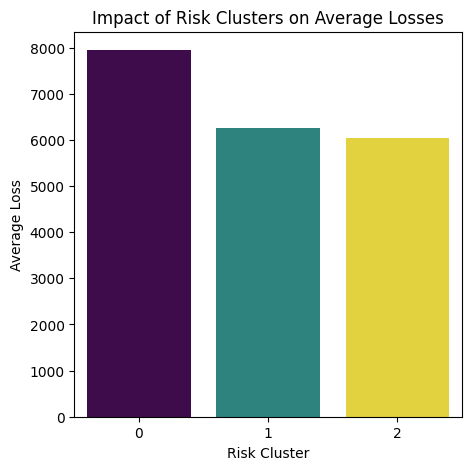

In [586]:
actual_claims['Frequency'] = actual_claims['ClaimNb'] / actual_claims['Exposure']
actual_claims['Severity'] = actual_claims['ClaimAmount'] / actual_claims['ClaimNb']

# Create a new column for total losses by multiplying frequency and severity of claims 
actual_claims['Total Loss'] = actual_claims['Frequency'] * actual_claims['Severity']

# Calculate the mean total losses for each predicted risk cluster
cluster_total_losses = actual_claims.groupby('Risk Cluster K-Mode')['Total Loss'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on total losses to see the riskiest cluster and the 'safest' cluster
plt.figure(figsize=(5, 5))
bar_plot = sns.barplot(data=cluster_total_losses, x='Risk Cluster K-Mode', y='Total Loss', hue='Risk Cluster K-Mode', palette='viridis', dodge=False, legend=False)

plt.title('Impact of Risk Clusters on Average Losses')
plt.xlabel('Risk Cluster')
plt.ylabel('Average Loss')
plt.show()

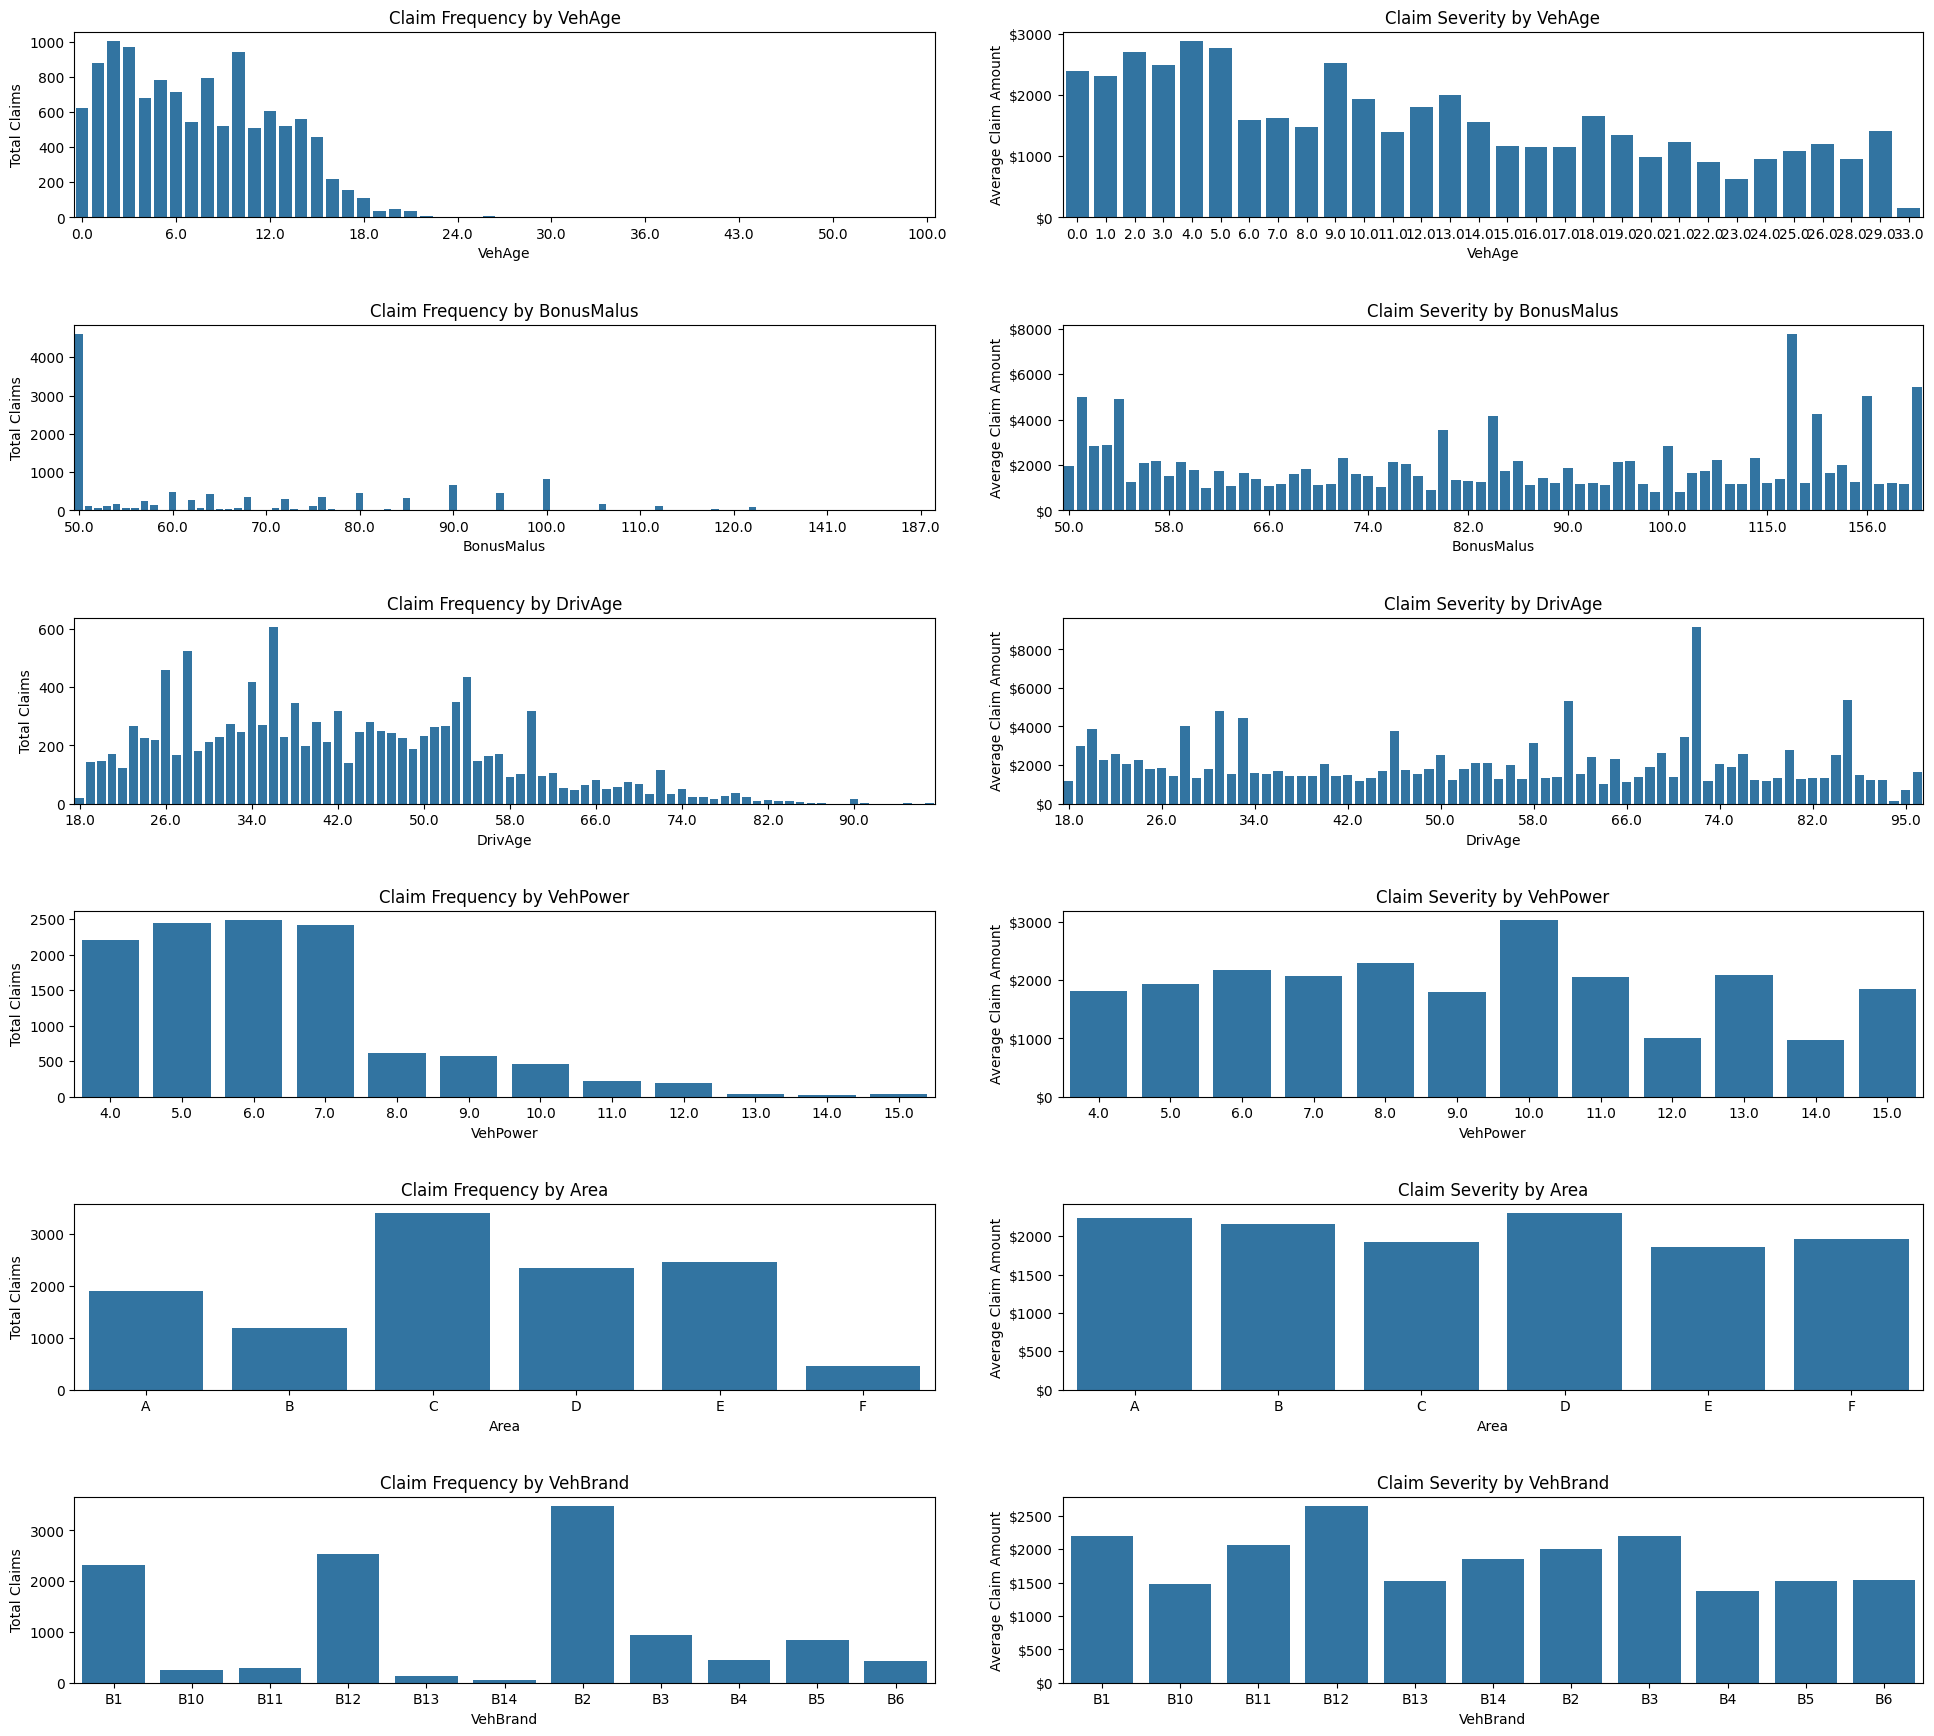

In [592]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area', 'VehBrand']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 3 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(actual_claims, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

**Interpretation**

This chart indicates that Cluster 0, which has the highest average loss, appears to be the riskiest cluster in the current data set. Interestingly, Cluster 1 held this position in last year's data. However, this shift aligns with typical fluctuations observed in yearly analyses.

For example, in the current data, the claim frequency for the `DrivAge` variable is concentrated around age 34, with claim severity remaining stable, except for a peak near age 70. In contrast, last year's data showed the highest claim frequency around ages 18 and 45, with significant spikes in claim severity at ages 18 and 82.

Aside from 'DriveAge', the other variables relevant to our clusters exhibit similar patterns in frequency and severity when compared to last year's dataset, reinforcing the consistency across most variables despite some shifts in cluster risk levels.

## 5.2 Premium determination 

In [576]:
# Create DataFrames based on clusters for further analysis (premium calculation, etc.)
real_cluster_0 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 0].copy()
real_cluster_1 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 1].copy()
real_cluster_2 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 2].copy()

# Create Frequency column (nb of claims per year)
real_cluster_0['Frequency'] = real_cluster_0['ClaimNb'] / real_cluster_0['Exposure'] #Number of claims per year
real_cluster_1['Frequency'] = real_cluster_1['ClaimNb'] / real_cluster_1['Exposure']
real_cluster_2['Frequency'] = real_cluster_2['ClaimNb'] / real_cluster_2['Exposure']

# Create Severity column (amount per claim)
real_cluster_0['Severity'] = real_cluster_0['ClaimAmount'] / real_cluster_0['ClaimNb'] 
real_cluster_1['Severity'] = real_cluster_1['ClaimAmount'] / real_cluster_1['ClaimNb']
real_cluster_2['Severity'] = real_cluster_2['ClaimAmount'] / real_cluster_2['ClaimNb']  

*Cluster 0*

In [577]:
# Cluster 0 
real_cluster_0['Premium_per_policy'] = real_cluster_0['Frequency'] * real_cluster_0['Severity']
real_cluster_0['Premium_per_policy'] = real_cluster_0['Premium_per_policy'].fillna(0)
real_premium_0 = real_cluster_0['Premium_per_policy'].mean()

print(f"The real premium for cluster 0 is: {real_premium_0:.2f}$")

The real premium for cluster 0 is: 258.82$


*Cluster 1*

In [578]:
# Cluster 1 
real_cluster_1['Premium_per_policy'] = real_cluster_1['Frequency'] * real_cluster_1['Severity']
real_cluster_1['Premium_per_policy'] = real_cluster_1['Premium_per_policy'].fillna(0)
real_premium_1 = real_cluster_1['Premium_per_policy'].mean()

print(f"The real premium for cluster 1 is: {real_premium_1:.2f}$")

The real premium for cluster 1 is: 266.51$


*Cluster 2*

In [579]:
# Cluster 2 
real_cluster_2['Premium_per_policy'] = real_cluster_2['Frequency'] * real_cluster_2['Severity']
real_cluster_2['Premium_per_policy'] = real_cluster_2['Premium_per_policy'].fillna(0)
real_premium_2 = real_cluster_2['Premium_per_policy'].mean()

print(f"The real premium for cluster 2 is: {real_premium_2:.2f}$")

The real premium for cluster 2 is: 266.93$


**Interpretation**

It's noteworthy that the premiums are now relatively similar across all clusters, with a premium of $258.82 for Cluster 0 (the 'riskiest' cluster by our analysis), $266.51 for Cluster 1, and $266.93 for Cluster 2. These close values suggest that the clusters exhibit similar levels of risk based on premium pricing.

This convergence could be attributed to changes in the frequency and severity patterns for the `DrivAge` variable. Last year’s data showed pronounced spikes in claim severity at ages 18 and 82. However, this trend has stabilized in the new data, with claim severity showing a more consistent pattern across different ages.

Interestingly, this observation relates to discussions we’ve had in class about the role of age in auto insurance pricing. As age-based variations in severity diminish, age may become less impactful in differentiating premiums among clusters. This stability in premiums across clusters might suggest that age, while traditionally a significant factor, could be losing its relevance as a primary risk determinant in our clustering model. Instead, age could serve more effectively as one of several factors contributing to overall risk profiles, rather than being a primary driver of premium differences.

Without sufficient differentiation in premiums, there’s a risk of adverse selection: higher-risk individuals may receive premiums similar to lower-risk individuals, allowing them to benefit disproportionately, while lower-risk individuals bear part of the cost for riskier clients. To push this analysis further, it would be interesting to test if the use of credit-based insurance scores improves our pricing.

## 5.3 Loss ratio

### Calculation of the loss ratio

In [581]:
# Computing loss ratios for each cluster 

total_severity_0 = real_cluster_0['Severity'].sum()
total_premiums_0 = real_cluster_0['Premium_per_policy'].sum()
loss_ratio_0 = total_severity_0 / total_premiums_0

total_severity_1 = real_cluster_1['Severity'].sum()
total_premiums_1 = real_cluster_1['Premium_per_policy'].sum()
loss_ratio_1 = total_severity_1 / total_premiums_1

total_severity_2 = real_cluster_2['Severity'].sum()
total_premiums_2 = real_cluster_2['Premium_per_policy'].sum()
loss_ratio_2 = total_severity_2 / total_premiums_2


print(f"The loss ratio for cluster 0 is: {loss_ratio_0:.2f}")
print(f"The loss ratio for cluster 1 is: {loss_ratio_1:.2f}")
print(f"The loss ratio for cluster 2 is: {loss_ratio_2:.2f}")

The loss ratio for cluster 0 is: 0.23
The loss ratio for cluster 1 is: 0.32
The loss ratio for cluster 2 is: 0.32


**Interpretation**

With loss ratios being relatively low and stable across all three clusters—0.23 for Cluster 0, and 0.32 for Clusters 1 and 2—we can confidently say that our analysis is sound. These loss ratios indicate that our premium calculations are sufficient to cover claims costs across all clusters while allowing for a buffer that contributes to profitability. The similar loss ratios for Clusters 1 and 2 further validate the consistency of our risk categorization, while the slightly lower loss ratio for Cluster 0 suggests either lower-than-expected risk or conservative premium pricing for this group. Overall, this stability in loss ratios confirms the reliability of our model and supports our premium pricing strategy.

# Problems we encountered

Throughout our analysis, we encountered several challenges that required careful consideration and additional research. First, fitting an appropriate distribution to our data proved difficult. We tested numerous distributions, including some outside the scope of our course, such as the Barr distribution, to find the best fit for our claims data. Another significant challenge was understanding how to structure our Monte Carlo simulation—whether to simulate separately for each cluster or to apply the simulation to the entire dataset. This decision had implications for both accuracy and computational efficiency, making it crucial to determine the best approach. Calculating the premium also presented obstacles; initially, our calculations yielded unreasonably high values, prompting us to conduct extensive research and refine our methodology. Finally, selecting a clustering method involved a trade-off between complexity and accuracy. We had to balance the desire for precise risk segmentation with the practicality of a simpler, more interpretable model.

# Adjustments after in-class discussion

Following our in-class discussion, we adjusted our approach to calculating the adjusted premium that meets the 0.5% condition. Initially, we calculated the percentile value (VaR) individually for each cluster, assuming that this would yield an appropriate adjusted premium. However, during the discussion, we learned that Value at Risk (VaR) is not additive, meaning that calculating VaR separately for each cluster does not correctly represent the combined risk. To address this, we modified our method by first determining the adjusted premium for total losses across all clusters, then allocating it proportionally based on each cluster's share of total losses.

# How we divided the work

Throughout this homework, we collaborated closely, with each person taking the lead on specific sections. Thomas led sections 1 and 2, Mariève led sections 4 and 5, and we jointly led section 3, fully sharing responsibility for its development. Although each of us held primary responsibility for certain sections, we consistently worked together on each part. This structure allowed us to leverage individual strengths while continuously exchanging ideas to find effective solutions.